Do this project again with scikit-learn<br>
* use linear regression: apply `LinearRegression` from `sklearn.linear_model` package
* use regularized regresion: apply `Ridge` from the same package

In [176]:
#import modules
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

#get dataset, clean it up 
df = pd.read_csv('data.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
string_columns = list(df.dtypes[df.dtypes == 'object'].index)
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [177]:
#splitting the dataset in different subsets
from sklearn.model_selection import train_test_split

In [178]:
#shuffling the data of df and splitting it into 2 sets
#df_train_full (80%), df_test (20%)
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [179]:
#take df_train_full and split it into train and val
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

In [180]:
#calculate logarithm of target variable
#because the distribution of the target variable has a 'long tail'
y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

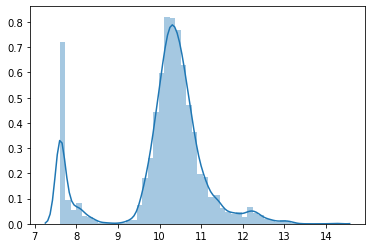

In [181]:
#check the value distribution of the target variable within the validation set
sns.distplot(y_val)

In [182]:
#define the first numerical features
#the new training set only contains the selected base columns
#empty values are replaced with 0
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']
df_num = df_train[base]
df_num = df_num.fillna(0)

#convert training set to dictionary
train_dict = df_num.to_dict(orient='rows')


In [183]:
#make use of DictVectorizer
#'dv' is a DictVectorizer instance
#if feature is categorical, it applies one-hot encoding
#if feature is numerical, it is left intact
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)


DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
               sparse=False)

In [184]:
#use 'transform' method to convert dictionary to matrix
X_train = dv.transform(train_dict)

In [185]:
#train logistic regression model
from sklearn.linear_model import LinearRegression
#train model by calling the 'fit' method
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [186]:
#prepare validation set
df_num = df_val[base]
df_num = df_num.fillna(0)

#do one-hot encoding for validation set
val_dict = df_num.to_dict(orient='rows')

#use 'transform' method to convert dictionaries to matrix
#'dv' for vectorization was already defined before
X_val = dv.transform(val_dict)

In [187]:
#use the model to predict the target variable
y_pred = model.predict(X_val)

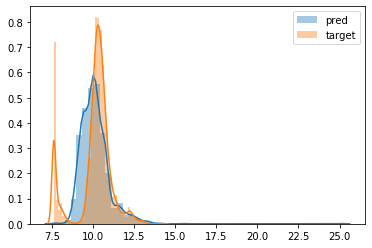

In [188]:
#the plot shows difference between distribution of 
#real target variable and predicted target variables in the validation set
#some of the predicted values are very high, so this prediction has a long tail 
sns.distplot(y_pred, label='pred')
sns.distplot(y_val, label='target')
plt.legend()

In [189]:
#calculation of the root mean squared error
#based on difference between distribution of 
#real target variable and predicted target variable
#this rmse is a bit higher than the rmse, calculated below
#where we directly built a model with mathematical formulas
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)
rmse(y_val, y_pred)

0.7983296104493073

Feature Engineering

In [190]:
#use prepare_X function to add 'age' feature 
def prepare_X(df):
    #create a copy to prevent side effects
    df = df.copy()
    #create copy of base list with basic features
    features = base.copy()
    
    #compute age feature and add it to features list
    df['age'] = 2017 - df.year
    features.append('age')
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    
    #do one-hot encoding for data set
    data_dict = df_num.to_dict(orient='rows')

    #use 'transform' method to convert dictionaries to matrix
    #'dv' for vectorization was already defined before
    dv.fit(data_dict)
    X_data = dv.transform(data_dict)
    return X_data


Validating the Model

In [191]:
#check if adding the feature 'age' can improve the model
#train the model
#within the 'prepare_X' function, we use df_train as an argument
#within the 'prepare_X' function, we include 'age' in the features
#the rmse 0.53 is nearly as good as the rmse 0.51, that was calculated with the mathematical formulas
X_train = prepare_X(df_train)
#train model by calling the 'fit' method
model = LinearRegression()
model.fit(X_train, y_train)

#apply model to validation dataset
X_val = prepare_X(df_val)
y_pred = model.predict(X_val)

#compute RMSE on validation dataset
print('validation:', rmse(y_val, y_pred))

validation: 0.5302719492079466


next step: include the features 'number of doors' and 'make'

In [192]:
#use prepare_X function to add 'age', 'number of doors' and 'make' features 
def prepare_X(df):
    #create a copy to prevent side effects
    df = df.copy()
    #create copy of base list with basic features
    features = base.copy()
    
    #compute age feature and add it to features list
    df['age'] = 2017 - df.year
    features.append('age')
    
    #add 'number of doors' and 'make'
    features.append('make')
    features.append('number_of_doors')
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    
    #do one-hot encoding for data set
    data_dict = df_num.to_dict(orient='rows')

    #use 'transform' method to convert dictionaries to matrix
    #'dv' for vectorization was already defined before
    dv.fit(data_dict)
    X_data = dv.transform(data_dict)
    return X_data


In [193]:
#check if adding the features 'make' and 'number_of_doors' can improve the model
#train the model
#within the 'prepare_X' function, we use df_train as an argument
#within the 'prepare_X' function, we include 'age', 'make' and 'number_of_doors' in the features
#the rmse is now 0.51, and improved compared to the rmse of 0.53, what we received from a model without 'make' 
#and 'number_of_doors' 
#the rmse 0.5105 is as good as the rmse 0.508, that was calculated with the mathematical formulas
X_train = prepare_X(df_train)
#train model by calling the 'fit' method
model = LinearRegression()
model.fit(X_train, y_train)

#apply model to validation dataset
X_val = prepare_X(df_val)
y_pred = model.predict(X_val)

#compute RMSE on validation dataset
print('validation:', rmse(y_val, y_pred))

validation: 0.5104665004535126


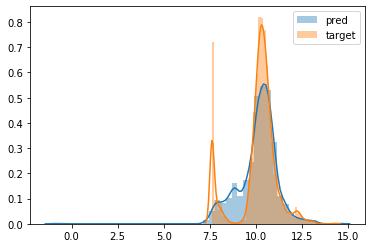

In [194]:
#plot the distributions of the real target variable (target)
#and the predicted target variable (pred)
#after whe included 'age', 'make' and 'number_of_doors' to the features
#but the model seems to produce some outliers
sns.distplot(y_pred, label='pred')
sns.distplot(y_val, label='target')
plt.legend()

Feature engineering: including further categorical features

In [195]:
#use prepare_X function to add 'age', 'number of doors' and 'make' features 
def prepare_X(df):
    #create a copy to prevent side effects
    df = df.copy()
    #create copy of base list with basic features
    features = base.copy()
    
    #compute age feature and add it to features list
    df['age'] = 2017 - df.year
    features.append('age')
    
    #add the rest of the features
    features.append('make')
    features.append('number_of_doors')
    features.append('transmission_type')
    features.append('driven_wheels')
    features.append('vehicle_size')
    features.append('vehicle_style')
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    
    #add extra rows as placeholders to df_num
    #df_num = df_num.set_value(len(df_num), 'engine_fuel_type', 'natural_gas').fillna(0)
    
    #do one-hot encoding for data set
    data_dict = df_num.to_dict(orient='rows')

    #use 'transform' method to convert dictionaries to matrix
    #'dv' for vectorization was already defined before
    dv.fit(data_dict)
    X_data = dv.transform(data_dict)
    return X_data

In [196]:
#check if adding further categorical features can continue to improve the rmse
#within the 'prepare_X' function, we use df_train as an argument
#within the 'prepare_X' function, we include 'age', 'make' and 'number_of_doors' in the features
#the rmse is now 0.55, and inreased compared to the rmse of 0.51, what we received from a model without
#the additional features
X_train = prepare_X(df_train)
#train model by calling the 'fit' method
model = LinearRegression()
model.fit(X_train, y_train)

#apply model to validation dataset
X_val = prepare_X(df_val)
y_pred = model.predict(X_val)

#compute RMSE on validation dataset
print('validation:', rmse(y_val, y_pred))

validation: 0.5464878641581602


Use ridge regression (regularization), to improve the rmse again

In [197]:
from sklearn.linear_model import Ridge

X_train = prepare_X(df_train)
#train model by calling the 'fit' method
clf = Ridge(alpha=1.0)
clf.fit(X_train, y_train)

#apply model to validation dataset
X_val = prepare_X(df_val)
y_pred = clf.predict(X_val)

#compute RMSE on validation dataset
print('validation:', rmse(y_val, y_pred))

validation: 0.5418919205620336


In [198]:
#adjust alpha and see if we can further improve the rmse
for r in [0, 0.001, 0.01, 0.1, 1, 10, 20, 30, 50, 100, 200]:
    X_train = prepare_X(df_train)
    #train model by calling the 'fit' method
    clf = Ridge(alpha=r)
    clf.fit(X_train, y_train)

    #apply model to validation dataset
    X_val = prepare_X(df_val)
    y_pred = clf.predict(X_val)

    #compute RMSE on validation dataset
    print('alpha:', r, 'validation:', rmse(y_val, y_pred))

alpha: 0 validation: 0.5503938438793762
alpha: 0.001 validation: 0.5464817902434599
alpha: 0.01 validation: 0.5464274511663981
alpha: 0.1 validation: 0.5459121176096232
alpha: 1 validation: 0.5418919205620336
alpha: 10 validation: 0.5222056306191918
alpha: 20 validation: 0.5150905147450261
alpha: 30 validation: 0.5120921152455405
alpha: 50 validation: 0.5096810559561592
alpha: 100 validation: 0.5082949543644409
alpha: 200 validation: 0.5084379162650191


If we use ridge regresssion, we can get the best rmse of 0.5083 with an alpha, what equals 100.

Test the model on the test set with an alpha of 100

In [203]:
X_train = prepare_X(df_train)
#train model by calling the 'fit' method
clf = Ridge(alpha=100)
clf.fit(X_train, y_train)

#apply model to validation dataset
X_test = prepare_X(df_test)
y_pred = clf.predict(X_test)

#compute RMSE on validation dataset
print('test:', rmse(y_test, y_pred))

test: 0.4472625512029258
